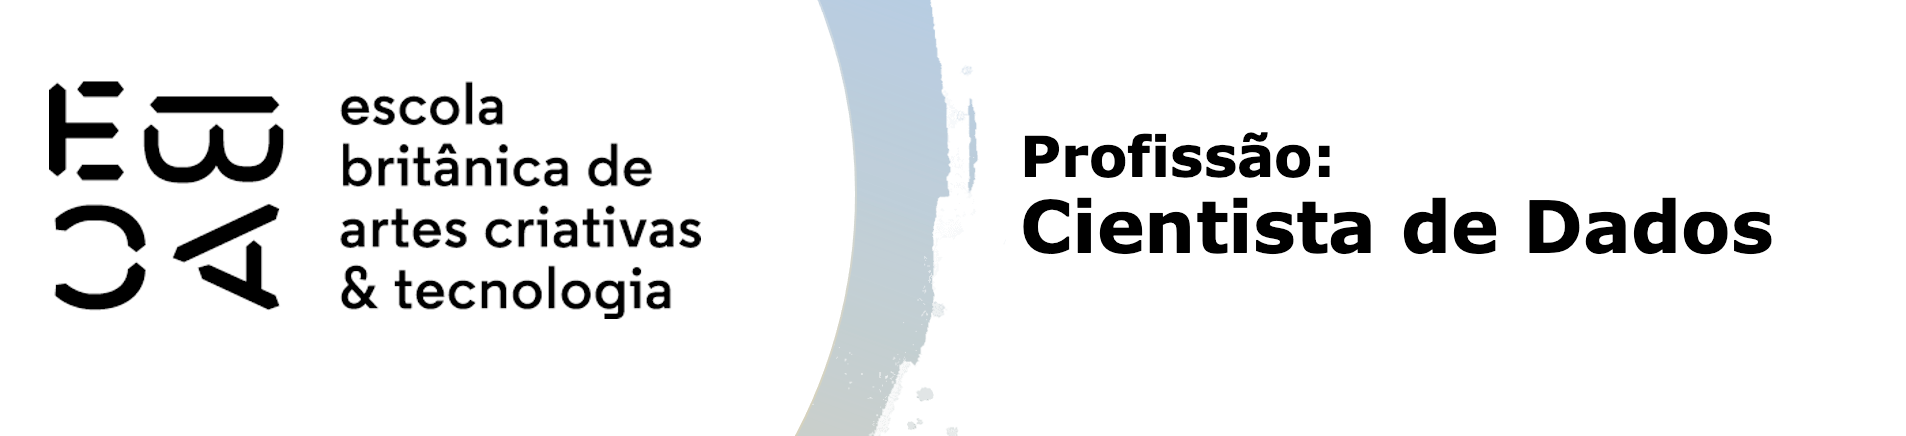

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif


from sklearn.metrics import r2_score



#ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [40]:
df = pd.read_csv('previsao_de_renda_II.csv')
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
df['log_renda'] = np.log(df['renda'])

df.data_ref = pd.to_datetime(df.data_ref)

X_test = df[df.data_ref >= '2016'].drop(columns=['index','data_ref','renda'])
X_train = df[df.data_ref < '2016'].drop(columns=['index','data_ref','renda'])
variaveis = X_train.columns
X_train.head()



,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,log_renda
0,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,9.318131
1,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,7.793508
2,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,9.528769
3,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,7.767196
4,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,6.673020


In [41]:
formula = '''log_renda ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'''

# Ajustando o modelo com todas as variáveis
res = smf.ols(formula, data=X_train).fit()

# Obtendo o R² ajustado
resultado_m1 = res
resultado_m1.summary().tables[0]

Dep. Variable:,log_renda,R-squared:,0.438
Model:,OLS,Adj. R-squared:,0.438
Method:,Least Squares,F-statistic:,1.947e+04
Date:,"Thu, 06 Mar 2025",Prob (F-statistic):,0.00
Time:,13:39:03,Log-Likelihood:,-7.9748e+05
No. Observations:,600000,AIC:,1.595e+06
Df Residuals:,599975,BIC:,1.595e+06
Df Model:,24,,
Covariance Type:,nonrobust,,


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

SIM! A distribuição aproximadamente em forma de sino, simétrica e centralizada em zero indica que a distribuição é NORMAL.


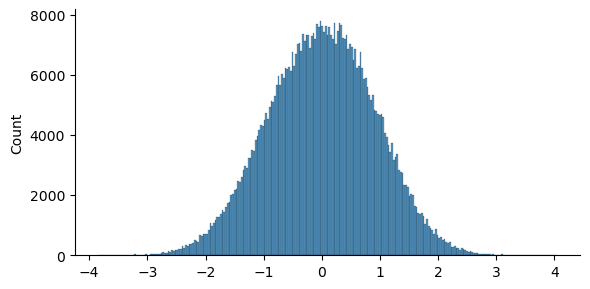

In [42]:
#verificando se a distribuição é NORAML
sns.displot(resultado_m1.resid, height=3, aspect=2);
print('SIM! A distribuição aproximadamente em forma de sino, simétrica e centralizada em zero indica que a distribuição é NORMAL.')

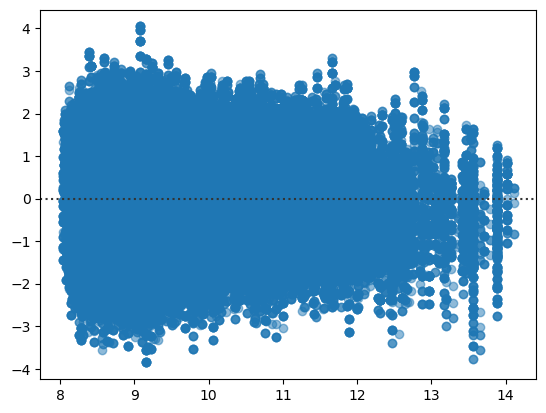

In [43]:
# resido x predito
sns.residplot(
    x=resultado_m1.predict(), 
    y=resultado_m1.resid,
    scatter_kws={'alpha': 0.5}
    );

In [44]:
X_train['predito'] = resultado_m1.predict()
X_train['residuo'] = resultado_m1.resid
X_train.head(2)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,log_renda,predito,residuo
0,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,9.318131,10.624447,-1.306317
1,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,7.793508,9.410457,-1.616948


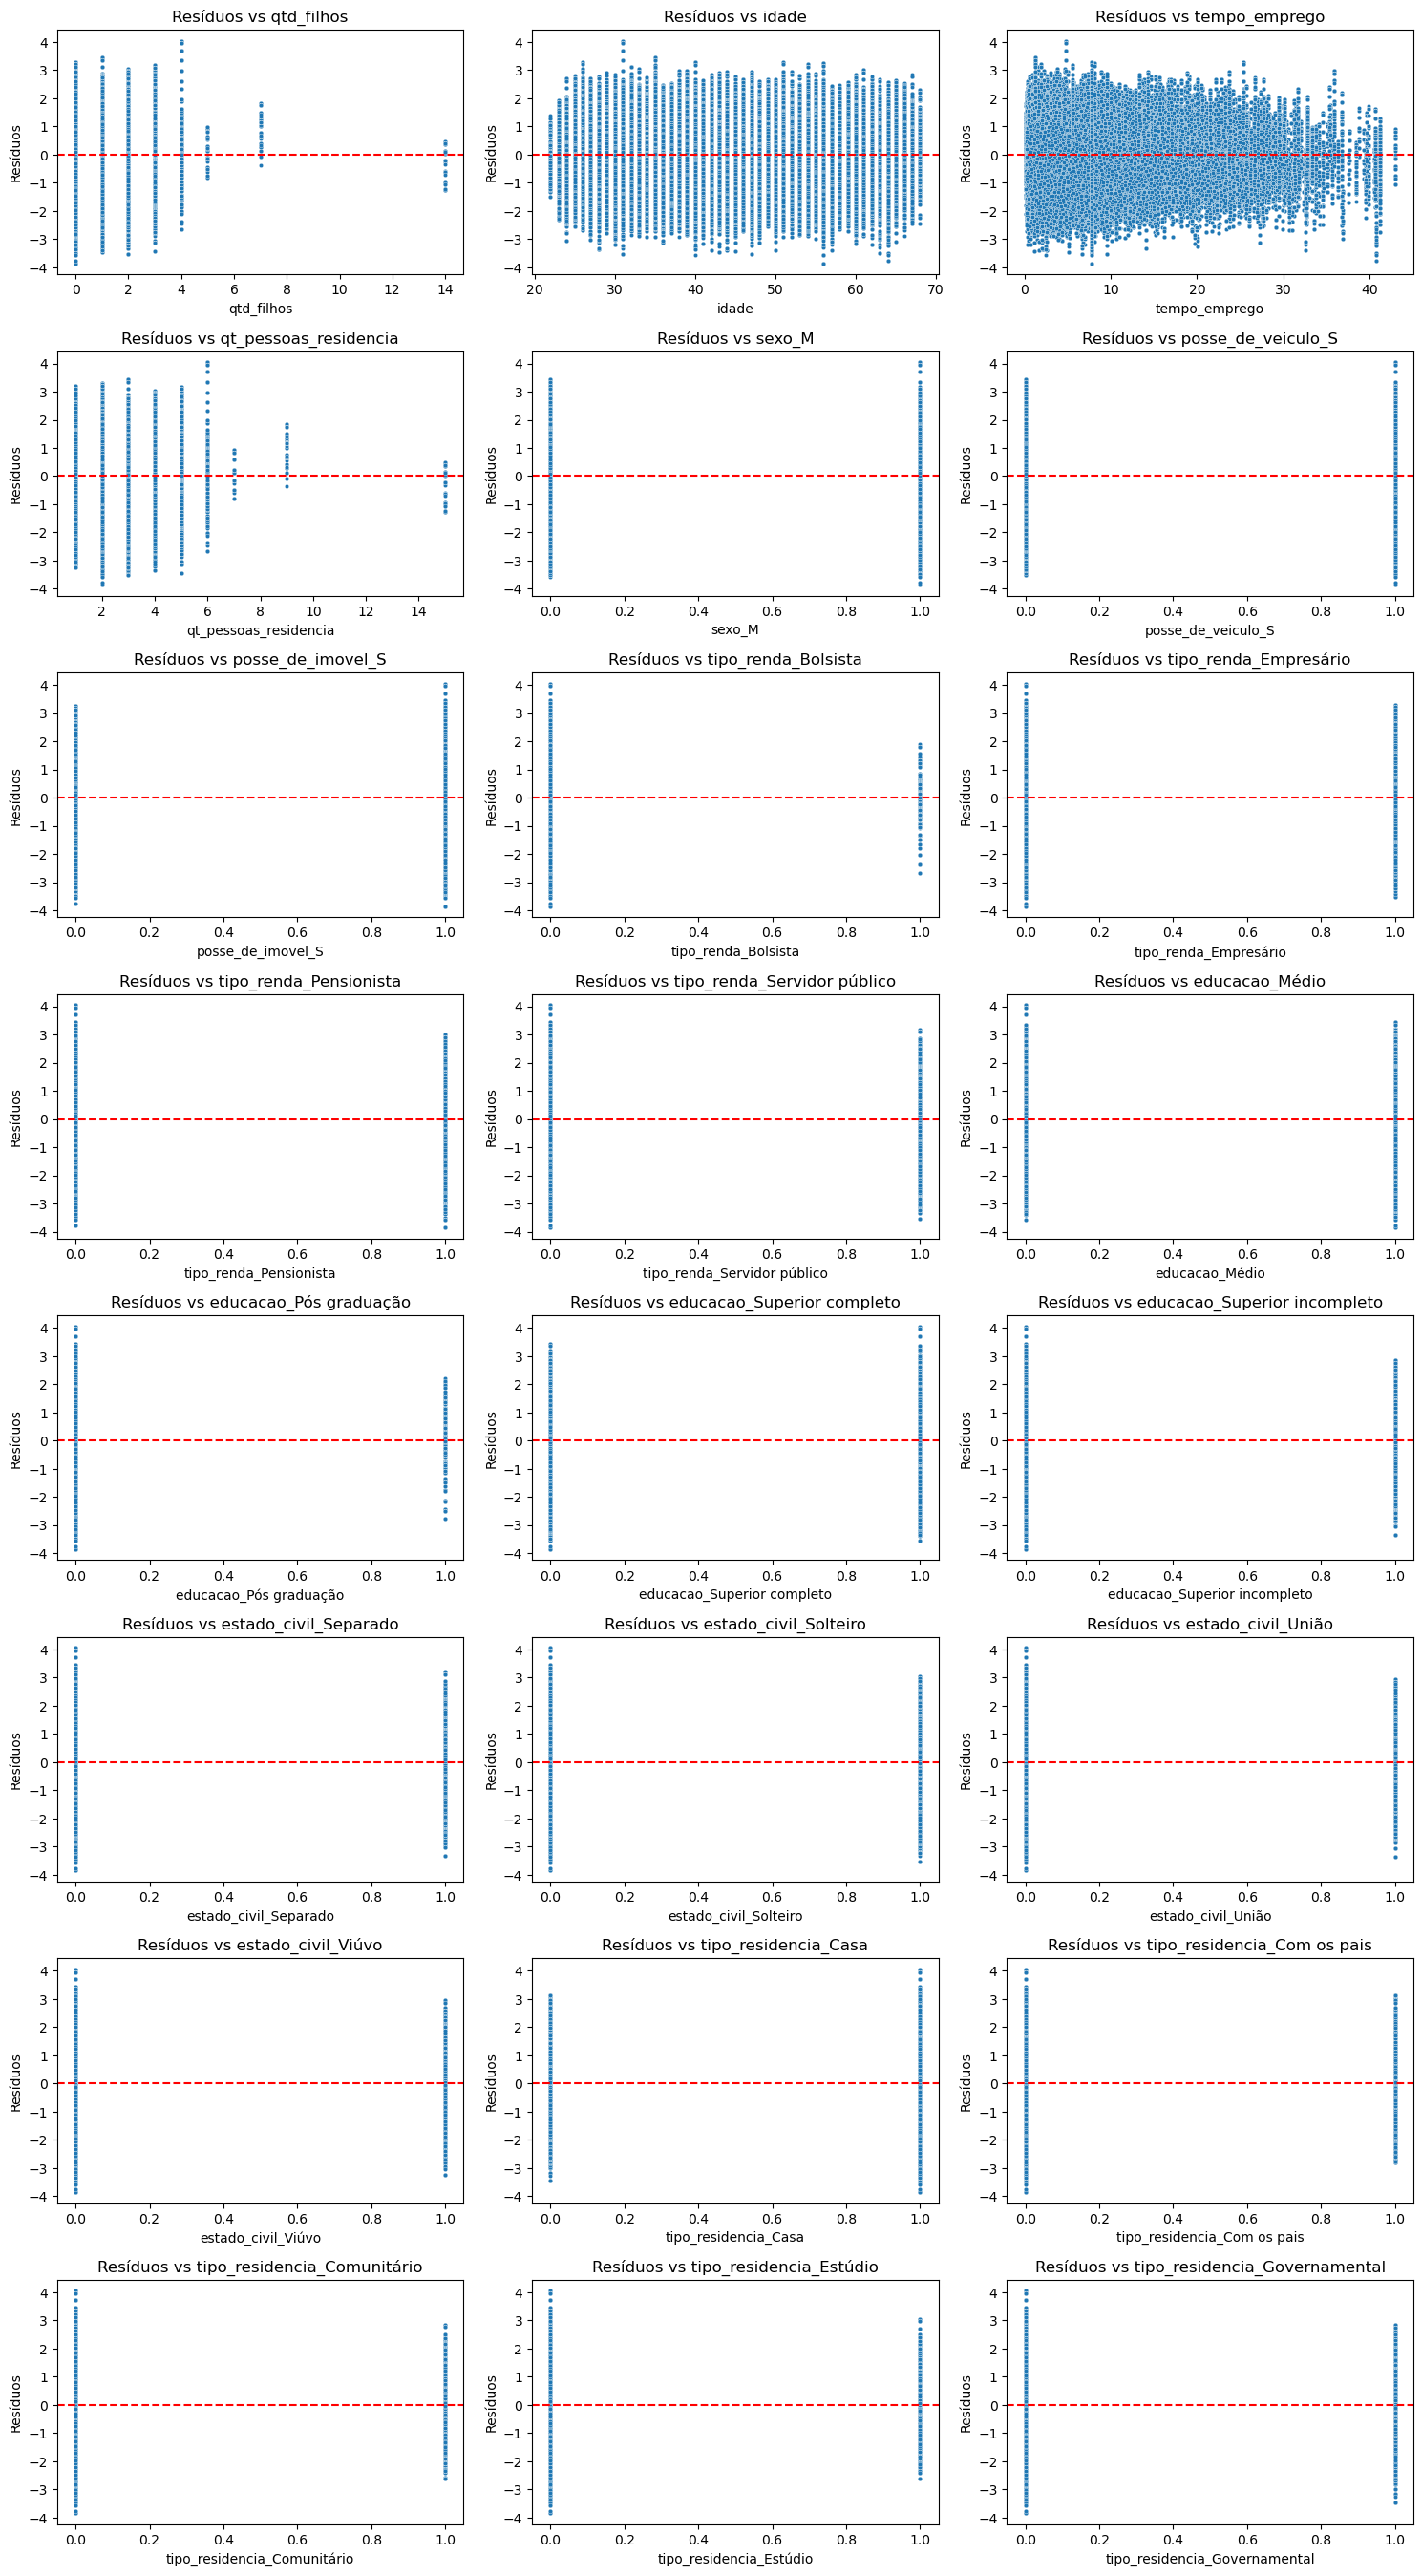

In [58]:

X_train_dummie = pd.get_dummies(X_train,drop_first=True)
# Plotando os resíduos em relação a cada variável independente
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 30))
axes = axes.flatten()
for i, col in enumerate(X_train_dummie.drop(columns=['predito','residuo','log_renda']).columns):  
    ax = axes[i]
    sns.scatterplot(x=X_train_dummie[col], y=X_train_dummie['residuo'], ax=ax, s=10)  
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'Resíduos vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Resíduos')

for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)


plt.tight_layout()
plt.show()

**Avaliação**: os resíduos são menores para maior tempo de emprego, demais variáveis não foi possível identificar uma correlação.

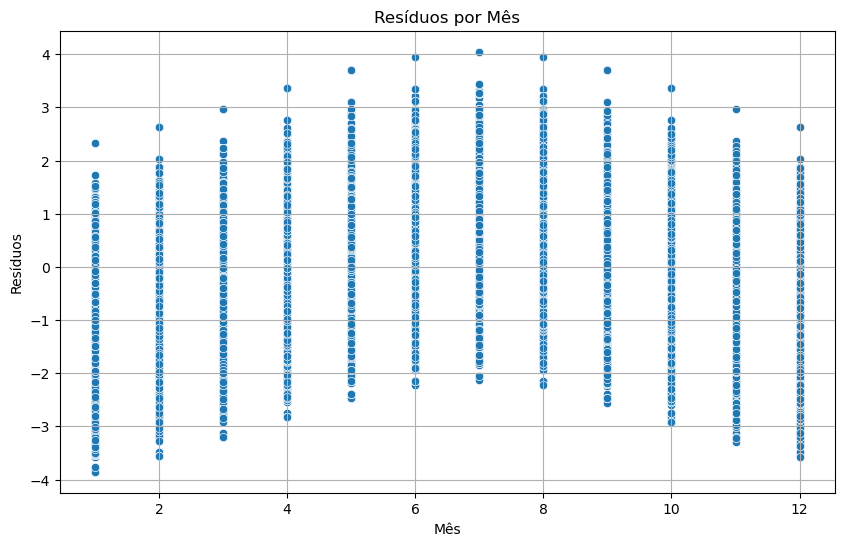

In [46]:
meses_train = df[df.data_ref < '2016'].data_ref.dt.month

plt.figure(figsize=(10, 6))
sns.scatterplot(x=meses_train, y=X_train_dummie['residuo'])
plt.title('Resíduos por Mês')
plt.xlabel('Mês')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()

**Avaliação:** apesar de visualmente haver um deslocamento dos resíduos no eixo y, o tamanho do range dos resíduos mês a mês permanece estável

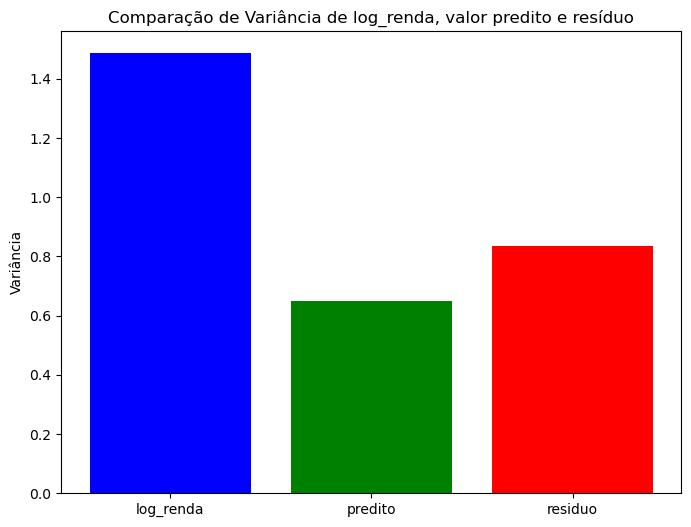

In [57]:
variancia_log_renda = X_train_dummie['log_renda'].var()
variancia_predito = X_train_dummie['predito'].var()
variancia_residuo = X_train_dummie['residuo'].var()

plt.figure(figsize=(8, 6))
plt.bar(['log_renda', 'predito','residuo'], [variancia_log_renda, variancia_predito,variancia_residuo],color=['blue', 'green','red'])
plt.ylabel('Variância')
plt.title('Comparação de Variância de log_renda, valor predito e resíduo')
plt.show()

**Avaliação:** a variancia do log_renda é maior que a variancia do valor predito e do resíduo.

**Avaliação:** Os testes e predições ocorreram de forma esperada, mas o modelo utilizando todas as variáveis para predizer o log_renda não é o mais ideal, os indices de predição estão abaixo do esperado, como podemos ver abaixo no resultado do modelo:

In [61]:
resultado_m1.summary().tables[0]

Dep. Variable:,log_renda,R-squared:,0.438
Model:,OLS,Adj. R-squared:,0.438
Method:,Least Squares,F-statistic:,1.947e+04
Date:,"Thu, 06 Mar 2025",Prob (F-statistic):,0.00
Time:,14:38:29,Log-Likelihood:,-7.9748e+05
No. Observations:,600000,AIC:,1.595e+06
Df Residuals:,599975,BIC:,1.595e+06
Df Model:,24,,
Covariance Type:,nonrobust,,


## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

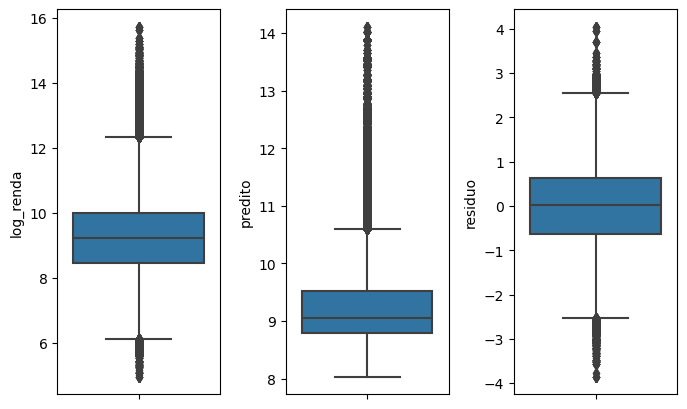

In [64]:
fig, ax = plt.subplots(1,3,figsize=(8, 5))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = 'log_renda',data=X_train, ax=ax[0])
sns.boxplot(y = 'predito',data=X_train, ax=ax[1])
sns.boxplot(y = 'residuo' ,data=X_train, ax=ax[2]);

In [71]:
#Avaliação studentizad residuals
pontos_influentes = resultado_m1.get_influence().resid_studentized_internal
pontos_influentes

array([-1.42905388, -1.76889746,  0.24742206, ...,  0.12266507,
        0.66005788, -1.2140287 ])

Os resíduos studentizados são uma versão padronizada dos resíduos comuns, onde cada resíduo é dividido por uma estimativa do seu erro padrão. Eles são úteis para:

- Identificar outliers (valores atípicos)
- Verificar se existem observações que têm uma influência desproporcional no modelo
- Avaliar se as premissas do modelo estão sendo violadas
Em geral, resíduos studentizados com valores absolutos maiores que 3 são considerados potencialmente problemáticos e merecem uma investigação mais detalhada.

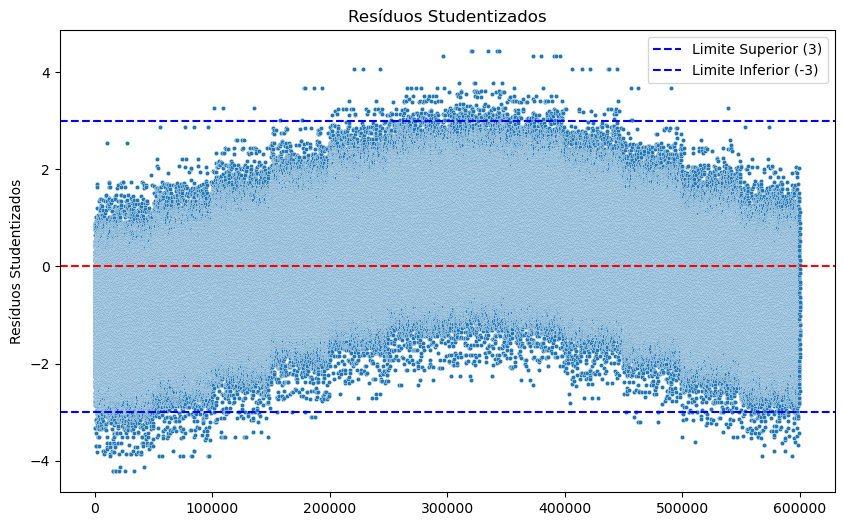

A porcentagem de outliers é de 0.17%


In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(pontos_influentes)), y=pontos_influentes, s=10)  # Ajuste o tamanho dos pontos
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=3, color='blue', linestyle='--', label='Limite Superior (3)')
plt.axhline(y=-3, color='blue', linestyle='--', label='Limite Inferior (-3)')
plt.title('Resíduos Studentizados')
plt.ylabel('Resíduos Studentizados')
plt.legend()
plt.show()

# Identificando os outliers
possiveis_outliers = np.where(np.abs(pontos_influentes) > 3)
print(f'A porcentagem de outliers é de {len(possiveis_outliers[0])/len(pontos_influentes)*100:.2f}%')

**Avaliação:** o indicador de outlier é muito baixo para haver influência.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

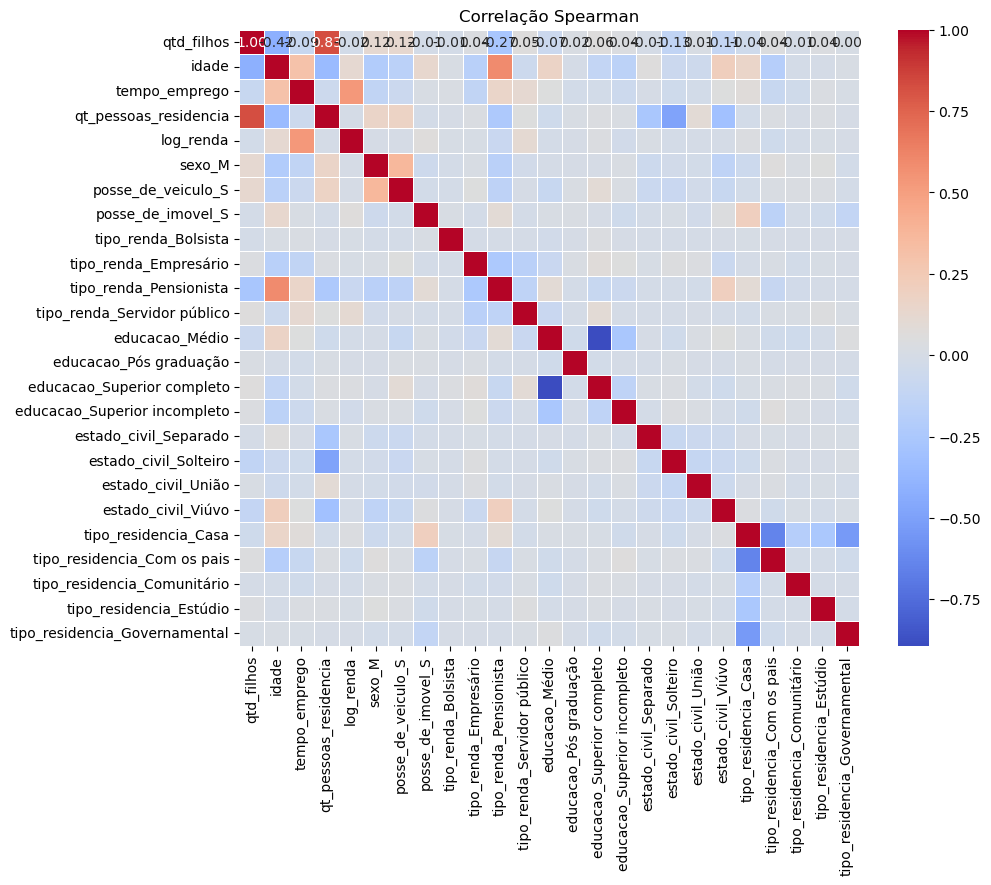

In [96]:
corr_spearman = X_train_dummie.drop(columns=['predito','residuo']).corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlação Spearman')
plt.show()

In [102]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(X_train_dummie.drop(columns=['predito','residuo','log_renda']).astype(float), i) for i in range(X_train_dummie.drop(columns=['predito','residuo','log_renda']).shape[1])]
vars_vif["Feature"] = X_train_dummie.drop(columns=['predito','residuo','log_renda']).columns

In [103]:
vars_vif.sort_values(by='VIF Factor',ascending=False)

,VIF Factor,Feature
3,241.886422,qt_pessoas_residencia
19,64.243851,tipo_residencia_Casa
11,52.802178,educacao_Médio
1,34.679117,idade
0,34.580520,qtd_filhos
13,28.614517,educacao_Superior completo
16,5.825763,estado_civil_Solteiro
14,4.338006,educacao_Superior incompleto
20,4.095181,tipo_residencia_Com os pais
15,3.479688,estado_civil_Separado


**Avaliação:** Existe uma correlação entre quantidade de pessoas na residencia e quantidade de filhos

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [132]:
def calculo_scores(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    print(f'R²: {r2}')
    print(f'R² Ajustado: {r2_adj}')

In [135]:
X_test['predito'] = resultado_m1.predict(X_test)
X_test['residuo'] = X_test['log_renda'] - X_test['predito']

In [167]:
X_train_novo = X_train.drop(columns=['predito','residuo'])
y_train_novo = X_train_novo['log_renda']
X_test_novo = X_test.drop(columns=['predito','residuo'])
y_test_novo = X_test_novo['log_renda']

In [171]:
formula = '''log_renda ~ posse_de_veiculo + posse_de_imovel + tipo_renda + educacao + tipo_residencia + tempo_emprego + qt_pessoas_residencia'''

# Ajustando o modelo com todas as variáveis
res = smf.ols(formula, data=X_train_novo).fit()

# Obtendo o R² ajustado
resultado_m2 = res
resultado_m2.summary().tables[0]

Dep. Variable:,log_renda,R-squared:,0.435
Model:,OLS,Adj. R-squared:,0.435
Method:,Least Squares,F-statistic:,2.717e+04
Date:,"Thu, 06 Mar 2025",Prob (F-statistic):,0.00
Time:,16:29:51,Log-Likelihood:,-7.9897e+05
No. Observations:,600000,AIC:,1.598e+06
Df Residuals:,599982,BIC:,1.598e+06
Df Model:,17,,
Covariance Type:,nonrobust,,


In [172]:
X_train_novo['predito'] = resultado_m2.predict(X_train_novo)
X_train_novo['residuo'] = X_train_novo['log_renda'] - X_train_novo['predito']

X_test_novo['predito'] = resultado_m2.predict(X_test_novo)
X_test_novo['residuo'] = X_test_novo['log_renda'] - X_test_novo['predito']

In [173]:
print('Resultados do primeiro modelo')
calculo_scores(X_test['log_renda'], X_test['predito'], len(resultado_m1.params) - 1)
print('##########')
calculo_scores(X_train['log_renda'], X_train['predito'], len(resultado_m1.params) - 1)

print('\nResultados do segundo modelo')
calculo_scores(X_test_novo['log_renda'], X_test_novo['predito'], len(resultado_m2.params) - 1)
print('##########')
calculo_scores(X_train_novo['log_renda'], X_train_novo['predito'], len(resultado_m2.params) - 1)

Resultados do primeiro modelo
R²: -0.6405585213239042
R² Ajustado: -0.6408210544428359
##########
R²: 0.4377819273690532
R² Ajustado: 0.4377594377090789

Resultados do segundo modelo
R²: -0.6404785877919947
R² Ajustado: -0.6406645310117975
##########
R²: 0.43497158515797896
R² Ajustado: 0.4349555755392699
